In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
GRID_SIZE = 20
NUM_AGENTS = 100
NUM_FOODS = 50

STEP_SIZE = 1
EAT_THRESHOLD = 2

N_DAYS = 50

SEED = 51

In [4]:
class Food:
    def __init__(self, position: tuple):
        self.position = position  # coordinates of food on env grid
        self.is_eaten = False  # can be alive or eaten
        
    def __repr__(self):
        return f"position={self.position}, is_eaten={self.is_eaten}"

In [5]:
class Agent:
    def __init__(self, position: tuple):
        self.position = position  # oordinates of agent on env grid
        self.energy = np.inf  # energy to be consumed walking
        self.food_eaten = 0  # amound of food items eaten
        self.is_dead = False # can be alive or dead

    def move(self, new_position):
        # move randomly on x or y by step size
        x, y = new_position
        self.position = x, y
        # consume energy equal to step size
        self.energy -= STEP_SIZE 
        
    def eat(self, food):
        # eat food and increase counter
        self.food_eaten += 1
        food.is_eaten = True

    def __repr__(self):
        return f"position={self.position}, is_dead={self.is_dead}, food_eaten={self.food_eaten}"

In [6]:
class Environment:
    np.random.seed(SEED)
    
    def __init__(self, grid_size=20, num_agents=10, num_foods=2):
        self.grid_size = grid_size
        self.num_foods = num_foods
        self.num_agents = num_agents
        self.foods = []
        self.agents = []
        self.initialize()
     
    def add_food(self):  # add food on the grid randomly
        for _ in range(self.num_foods):
            x = random.uniform(0, self.grid_size)
            y = random.uniform(0, self.grid_size)
            food = Food((x, y))
            self.foods.append(food)

    def add_agents(self):  # add agents on the grid edges randomly
        for _ in range(self.num_agents):
            if np.random.random() > 0.5:
                x, y = 0, random.uniform(0, self.grid_size)
            else:
                x, y = random.uniform(0, self.grid_size), 0
            agent = Agent((x, y))
            self.agents.append(agent)
            
    def initialize(self):
        self.add_food()
        self.add_agents()
            
    def restart(self):  # restart the grid (when game is over)
        self.foods = []
        self.agents = []
        self.initialize()

    def move_agent(self, agent):
        x, y = agent.position
        if np.random.random() > 0.5:
            new_x = x
            new_y = (y + STEP_SIZE) % self.grid_size
        else:
            new_x = (x + STEP_SIZE) % self.grid_size
            new_y = y 
        new_position = new_x, new_y
        agent.move(new_position)
        
    def interact_agent(self, agent):
        for food in self.foods:
            distance = np.linalg.norm(np.array(agent.position) - np.array(food.position))
            if distance < EAT_THRESHOLD:
                agent.eat(food)
                self.foods = [food for food in self.foods if not food.is_eaten]
                
    def select_agent(self, agent):
        if agent.energy <= 0:
            agent.is_dead = True
        self.agents = [agent for agent in self.agents if not agent.is_dead]
          
    def step(self):
        for agent in self.agents:
            self.move_agent(agent)
            self.interact_agent(agent)
            self.select_agent(agent)
            
    def is_game_over(self):  # game over when no more food is left
            return len(env.foods) == 0 or len(env.agents) <= 0
        
    def update(self, verbose=False):
        num_agents_dead = len([agent for agent in env.agents if agent.food_eaten == 0])
        num_agents_reproduced = len([agent for agent in env.agents if agent.food_eaten >= 2])
        if verbose:
            print(f"{num_agents_dead} agents died, {num_agents_reproduced} reproduced")
        env.num_agents = env.num_agents - num_agents_dead + num_agents_reproduced
        
    def visualize(self):
        fig, ax = plt.subplots()
        if self.foods:
            food_x, food_y = zip(*[food.position for food in self.foods])
        else:
            food_x, food_y = None, None
        ax.scatter(food_x, food_y, c='red', label='Food')
        agent_x, agent_y = zip(*[agent.position for agent in self.agents])
        ax.scatter(agent_x, agent_y, c='blue', label='Agents')
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_xlabel('X-coordinate')
        ax.set_ylabel('Y-coordinate')
        ax.legend()
        plt.pause(0.1)  
        plt.show() 
        
    def __repr__(self):
        return f"Agents: {self.agents}, \nFood: {self.foods}"

In [7]:
env = Environment(grid_size=GRID_SIZE, num_agents=NUM_AGENTS, num_foods=NUM_FOODS)

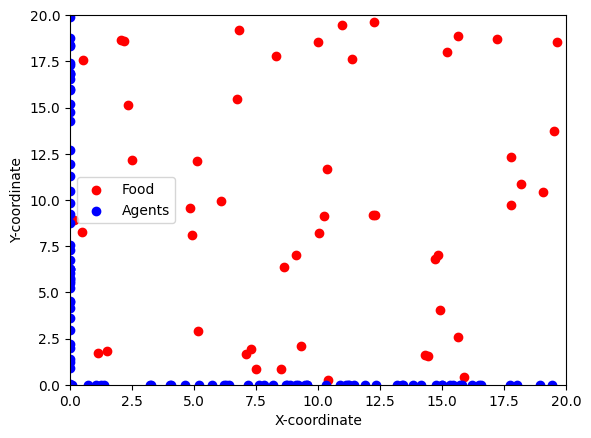

In [8]:
env.visualize()

In [9]:
# this is one loop for "a day"
# our buddies move randomly and eat until the food is over

def day_loop():
    done = False
    while not done:
        env.step()
        done = env.is_game_over()
    env.update(verbose=False)

In [14]:
# main loop over N_DAYS passed as global variable
# store the agents amount at each day to study relation with food

agents_per_day = np.zeros(N_DAYS, dtype=int)

for day in range(N_DAYS):
    agents_per_day[day] = env.num_agents
    # print(f"{env.num_agents} agents alive")
    day_loop()
    env.restart()

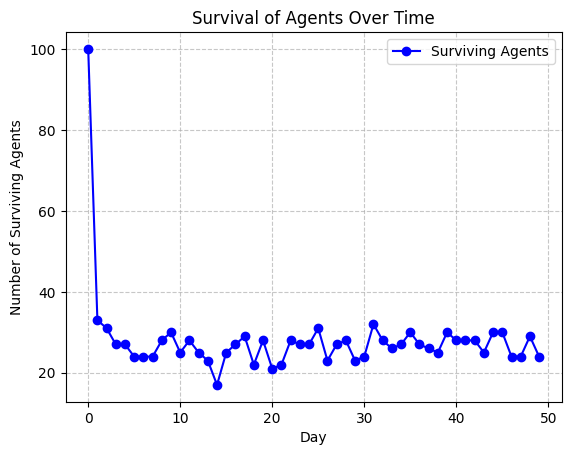

In [13]:
fig, ax = plt.subplots()

plt.plot(agents_per_day, marker='o', linestyle='-', color='b', label='Surviving Agents')
plt.xlabel('Day')
plt.ylabel('Number of Surviving Agents')
plt.title('Survival of Agents Over Time')
plt.grid(True, linestyle='--', alpha=0.7)

plt.legend()
plt.show()